In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io

In [3]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150
for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/Brain_tumor_classification/brain_tumor_classification_dataset/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('/content/drive/MyDrive/Brain_tumor_classification/brain_tumor_classification_dataset/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 74/74 [00:15<00:00,  4.66it/s]


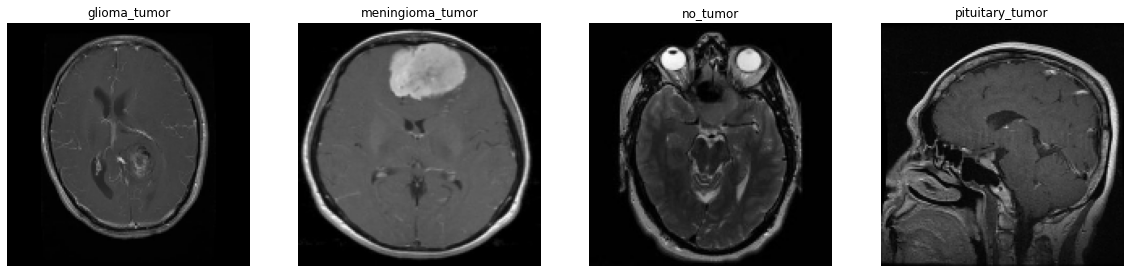

In [4]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
k = 0
for i in range(0,4):
    if i==0: idx=0
    elif i==1: idx=827
    elif i==2: idx=1649
    else: idx=2045
    ax[k].imshow(X_train[idx])
    ax[k].set_title(Y_train[idx])
    ax[k].axis('off')
    k+=1

In [5]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=28)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


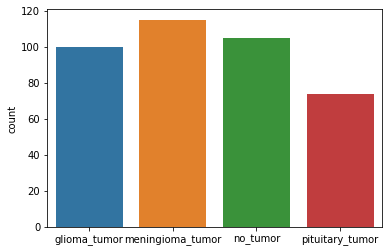

In [6]:
sns.countplot(Y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


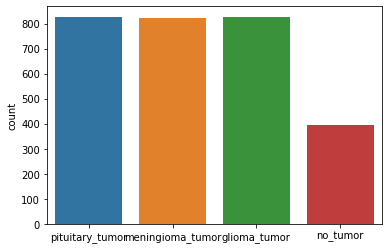

In [7]:
sns.countplot(Y_train)

In [8]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=28)

In [10]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model

In [12]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [13]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain_tumor_classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [16]:
datagen = ImageDataGenerator(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=10,
zoom_range=0.1,
width_shift_range=0.1,
horizontal_flip=False,
vertical_flip=False)

datagen.fit(X_train)

In [17]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              validation_data=(X_val, Y_val), 
                              epochs=30, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
72/72 [==============================] - 68s 390ms/step - loss: 0.4311 - accuracy: 0.8367 - val_loss: 0.9301 - val_accuracy: 0.7265

Epoch 00001: val_accuracy improved from -inf to 0.72648, saving model to brain_tumor_classification.h5
Epoch 2/30
72/72 [==============================] - 23s 314ms/step - loss: 0.2236 - accuracy: 0.9203 - val_loss: 0.6409 - val_accuracy: 0.8554

Epoch 00002: val_accuracy improved from 0.72648 to 0.85540, saving model to brain_tumor_classification.h5
Epoch 3/30
72/72 [==============================] - 23s 311ms/step - loss: 0.1618 - accuracy: 0.9464 - val_loss: 0.4226 - val_accuracy: 0.9059

Epoch 00003: val_accuracy improved from 0.85540 to 0.90592, saving model to brain_tumor_classification.h5
Epoch 4/30
72/72 [==============================] - 23s 312ms/step - loss: 0.0973 - accuracy: 0.9652 - val_loss: 1.4518 - val_accuracy: 0.7561

Epoch 00004: val_accuracy did not improve from 0.90592
Epoch 5/30
72/72 [==============================] - 23

In [18]:
model.save('/content/drive/MyDrive/Brain_tumor_classification/brain_tumor_classification_dataset/model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


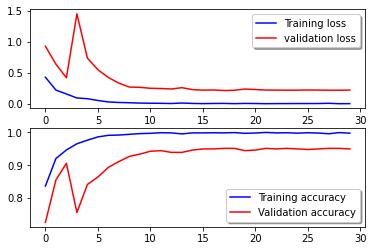

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

In [21]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 78.93%


In [22]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        p='Meningioma Tumor'
    elif p==2:
        print('The model predicts that there is no tumor')
    else:
        p='Pituitary Tumor'

    if p!=2:
        print(f'The Model predicts that it is a {p}')

In [23]:
uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')